![](../docs/ae_logo.png "Adapt & Enable")
# AE workshop 2023 - Data science

## Part 2 - Time Series Forecasting

We've explored the data and got a feel for it. Let's move on, and see if we can build a model that predicts the temperature for future points in time! 

First things first, let's import what we need.

In [1]:
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsforecast import StatsForecast
from statsforecast.models import *
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    explained_variance_score,
)

pd.options.plotting.backend = "plotly"
import warnings
from tqdm import TqdmExperimentalWarning

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=TqdmExperimentalWarning)
import plotly.io as pio

pio.templates.default = "plotly_white"

ae_orange = "#FD9129"
ae_orange2 = "#FFD580"
ae_gold = "#FFD700"

/Users/wouter/Documents/Repositories/ae/workshop_forecasting_2023/venv/lib/python3.9/site-packages/statsforecast/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Read data

Let's load the data we saved from the previous step. If the next cell fails, *make sure you ran through the entire [EDA notebook](./1_EDA.ipynb)*.

In [2]:
df = pd.read_csv("../data/cleaned.csv")
df.index = df.date
df = df.drop(columns=["date"])
df.head()

temperature  uncertainty  month  year
date                                             
1750-01-01        3.034        3.574      1  1750
1750-02-01        3.083        3.702      2  1750
1750-03-01        5.626        3.076      3  1750
1750-04-01        8.490        2.451      4  1750
1750-05-01       11.573        2.072      5  1750

Alright, looks good! Let's get started. 

### Train-val-test split

First, as with any machine learning algorithm, we'll want to define on which data we'll **train** the model, and which part we'll use to **validate** whether our model is any good. In addition, we should define a hold-out **test** set. Validation splits can be used to tweak our model (and its hyperparameters), but the test set serves to yield a final benchmark for our model's performance. We'll skip the test set for this workshop, just this once.

We'll do this in a simple way, setting aside the final segments of the data for validation. It's good to be aware of slightly more complex strategies, such as the use of [sklearn's TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html). Since regular randomized cross-validation won't work for time series (you can figure out why, right?), other validation strategies were cooked up, such as *rolling window cross-validation* or *walk-forward validation*. The latter is implemented in `TimeSeriesSplit`.

![TimeSeriesSplit](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_013.png)

In [3]:
# Helper function to generate splits
def train_val_test_split(data: pd.DataFrame, train=0.7, val=0.15, test=0.15):
    # Make sure our splits add up
    total = train + test + val
    if not total == 1:
        print(
            f"Train, validation and test portions don't add up to 1! Currently the total is{total}. Rebalancing."
        )
        train /= total
        val /= total
        test /= total

    # Calculate row counts
    n_rows = len(data)
    train_rows = int(train * n_rows)
    val_rows = int(val * n_rows)
    test_rows = n_rows - (train_rows + val_rows)

    # Slice up the data
    train_data = data.iloc[:train_rows]
    val_data = data.iloc[train_rows : train_rows + val_rows]
    test_data = data.iloc[train_rows + val_rows :]

    print(
        f"Training split:   {train_rows} data points\tfrom {train_data.index.min()} till {train_data.index.max()}"
    )
    print(
        f"Validation split: {val_rows} data points\tfrom {val_data.index.min()} till {val_data.index.max()}"
    )
    print(
        f"Test split:       {test_rows} data points\tfrom {test_data.index.min()} till {test_data.index.max()}"
    )

    return train_data, val_data, test_data

In [4]:
train, val, test = train_val_test_split(df, train=0.8, val=0.2, test=0)

Training split:   2544 data points	from 1750-01-01 till 1962-12-01
Validation split: 636 data points	from 1963-01-01 till 2015-12-01
Test split:       0 data points	from nan till nan


### 1. Statistical modelling: ARIMA (and friends)

We'll first try and fit an **A**uto**r**egressive **I**ntegrated **M**oving **A**verage model. That's a mouthful, we know. This statistical model is quite common in the industry (e.g., in stock price forecasting). 

* It's *autoregressive* because it uses past values of a variable to predict its future values (i.e., it regresses onto itself). 
* It uses a *moving average* of the past errors to predict future errors. 
* Finally, it's *integrated* in the sense that it uses differencing to make the data stationary -- that is, it removes trends and seasonal patterns to try and obtain a stationary signal.

Let's fit one! Here, we will use a class called `AutoARIMA`, which automatically finds the best ARIMA model based on an information criterion.

In [5]:
# Many of these packages are picky about the column names, so here's a helper function to prep the data
def prep_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.reset_index()
    df = df.rename(columns={"date": "ds", "temperature": "y"})
    df["unique_id"] = 1
    df = df[["unique_id", "ds", "y"]]

    return df

In [6]:
train_sf = prep_df(train)
val_sf = prep_df(val)

In [7]:
season_length = 12  # Monthly data
horizon = len(val)  # Predict the length of the validation df

# Include the models you imported
models = [
    # This is a baseline model
    HistoricAverage(),
    # This is a better model
    AutoARIMA(season_length=season_length),
    # YOU CAN ADD MODELS HERE
]

# Instantiate the StatsForecast class as sf
sf = StatsForecast(df=train_sf, models=models, freq="MS", n_jobs=-1)

# Forecast for the defined horizon
forecast = sf.forecast(horizon)

In [8]:
forecast.head()

ds  HistoricAverage  AutoARIMA
unique_id                                       
1         1963-01-01         8.203653   2.947784
1         1963-02-01         8.203653   3.428498
1         1963-03-01         8.203653   5.249260
1         1963-04-01         8.203653   8.438313
1         1963-05-01         8.203653  11.231355

As you can see, the forecast data frame now has an `AutoARIMA` column with forecast values, corresponding to the validation dates.

If you add another type of model to the list, they'll show up here as extra columns. **Have a look [here](https://github.com/Nixtla/statsforecast) if you're curious, or just want to play around.**

Before we calculate performance metrics, let's visualize our predictions!

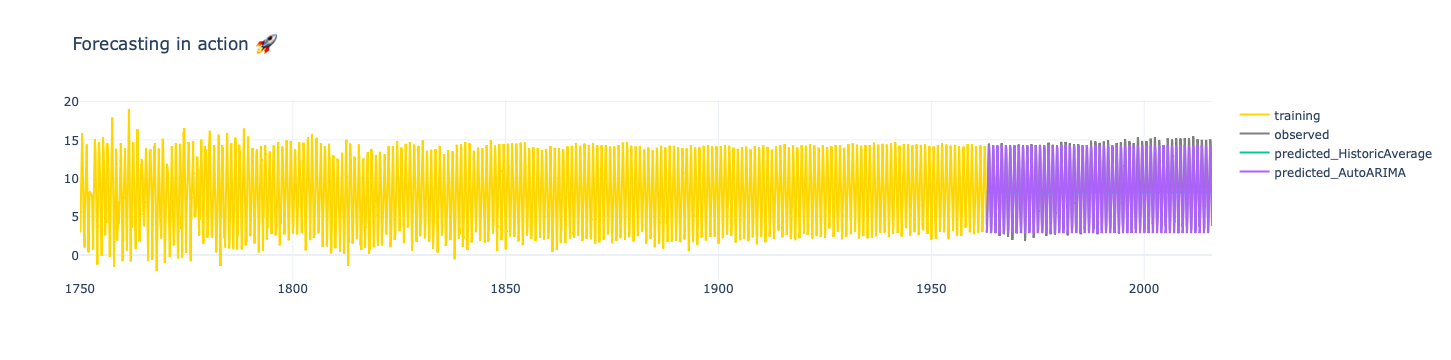

In [9]:
base_plots = []
prediction_plots = []

# Plot our training data
base_plots.append(
    go.Scatter(
        x=train.index,
        y=train.temperature,
        mode="lines",
        name="training",
        line=dict(color=ae_gold),
    )
)

# Plot our observed validation values
base_plots.append(
    go.Scatter(
        x=val.index,
        y=val.temperature,
        mode="lines",
        name="observed",
        line=dict(color="grey"),
    )
)

# Plot our ARIMA prediction
for model in forecast.columns[1:]:
    prediction_plots.append(
        go.Scatter(
            x=forecast.ds, y=forecast[model], mode="lines", name=f"predicted_{model}"
        )
    )

# Display
fig = go.Figure(data=base_plots + prediction_plots)
fig.update_layout(title="Forecasting in action 🚀")

fig.show()

Not bad! Let's calculate some performance metrics.

In [10]:
# Helper function to give us some basic time series forecasting performance metrics
def forecast_metrics(y_true, y_pred):
    # Collect metrics in a dictionary
    metrics = {}

    metrics["MSE"] = mean_squared_error(y_true, y_pred)
    metrics["MAE"] = mean_absolute_error(y_true, y_pred)
    metrics["RMSE"] = np.sqrt(metrics["MSE"])
    metrics["R-squared"] = r2_score(y_true, y_pred)
    metrics["EV"] = explained_variance_score(y_true, y_pred)

    return metrics

In [11]:
# These models were implemented
models = forecast.columns[1:]

# Let's calculate and store metrics for every one of them
results = dict()
for model in models:
    results[model] = forecast_metrics(val.temperature, forecast[model])

In [12]:
results_df = pd.DataFrame(results)
results_df

HistoricAverage  AutoARIMA
MSE              17.998435   0.385591
MAE               3.812531   0.494046
RMSE              4.242456   0.620960
R-squared        -0.042374   0.977669
EV                0.000000   0.986248

In [13]:
# Helper function to visualize performance
def visualize_metrics(results_df: pd.DataFrame, baseline=True):
    # Don't mess with our original data
    viz_df = results_df.copy()

    # Get rid of baseline if not requested
    if not baseline:
        del viz_df["HistoricAverage"]

    # Create subplot grid with one row per metric
    fig = make_subplots(rows=1, cols=viz_df.shape[0], horizontal_spacing=0.1)

    # Loop through each row and add a bar chart to the corresponding subplot
    for idx, (name, row) in enumerate(viz_df.iterrows()):
        fig.add_trace(go.Bar(x=row.index, y=row.values, name=name), row=1, col=idx + 1)
        # Give the child a name
        fig.update_yaxes(title_text=name, row=1, col=idx + 1)

    # Update layout and show the figure
    fig.update_layout(
        height=400, width=1200, title="Model comparison", showlegend=False
    )
    fig.show()

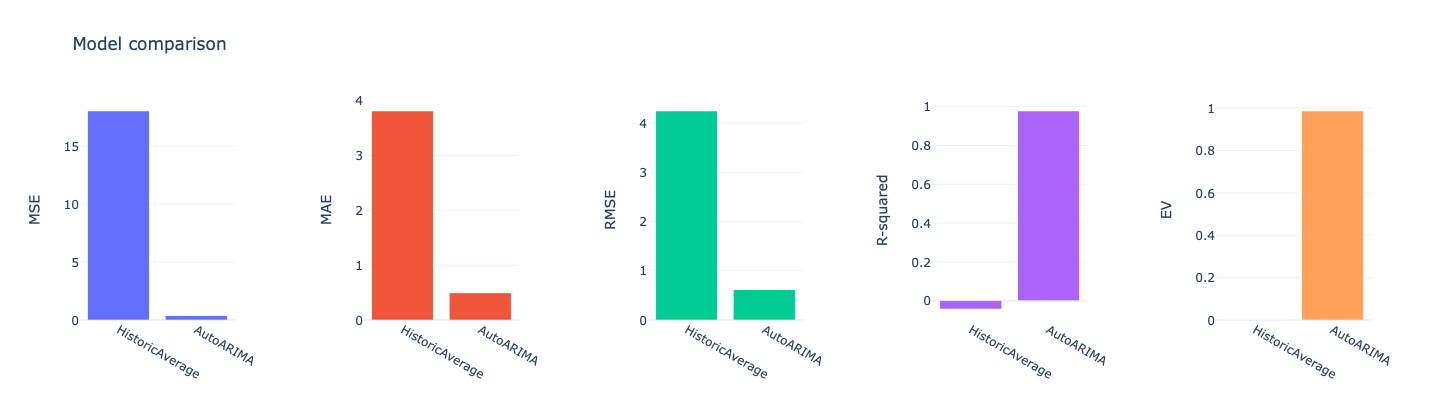

In [14]:
visualize_metrics(results_df)

Clearly, the ARIMA approach blows the baseline model out of the water. Good! Now let's try another model: Facebook's [Prophet](https://facebook.github.io/prophet/)!

### 2. Prophet

> Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

Prophet is a special case of the Generalized Additive Model. Whereas ARIMA tries to build a formula for future values as a function of past values, Prophet tries to detect “change points”; you can think of Prophet as curve-fitting.

In [15]:
from prophet import Prophet

In [16]:
model = Prophet()
model.fit(train_sf)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -148.717
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6533.16   0.000667074       131.521      0.6256      0.6256      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     171       6535.24   8.10471e-05       127.526   9.643e-07       0.001      246  LS failed, Hessian reset 
     199        6535.5   0.000220014       110.697           1           1      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238        6536.1   0.000210891       181.392   1.964e-06       0.001      366  LS failed, Hessian reset 
     299       6536.47   0.000872128        71.025           1           1      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     322       6536.55   7.72767e-05        137.43   8.114e-07       0.001      512  LS failed, Hessian rese

In [17]:
future = model.make_future_dataframe(periods=len(val), freq="MS")
forecast = model.predict(future)[-len(val) :]

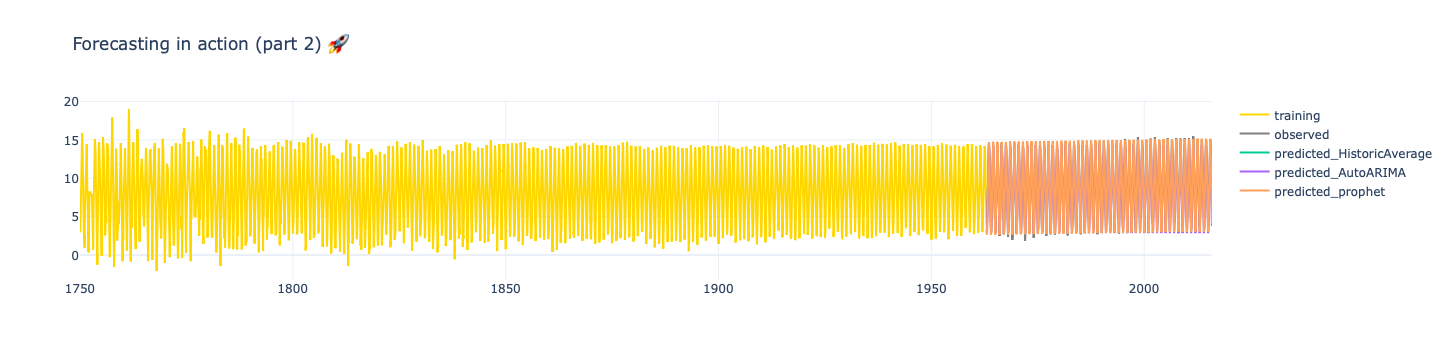

In [18]:
# Plot prophet's prediction
prophet_plot = [
    go.Scatter(x=forecast.ds, y=forecast.yhat, mode="lines", name="predicted_prophet")
]

# Display
fig = go.Figure(data=base_plots + prediction_plots + prophet_plot)
fig.update_layout(title="Forecasting in action (part 2) 🚀")

fig.show()

In [19]:
results["Prophet"] = forecast_metrics(val.temperature, forecast.yhat)
results_df = pd.DataFrame(results)
results_df

HistoricAverage  AutoARIMA   Prophet
MSE              17.998435   0.385591  0.197164
MAE               3.812531   0.494046  0.355872
RMSE              4.242456   0.620960  0.444031
R-squared        -0.042374   0.977669  0.988581
EV                0.000000   0.986248  0.988809

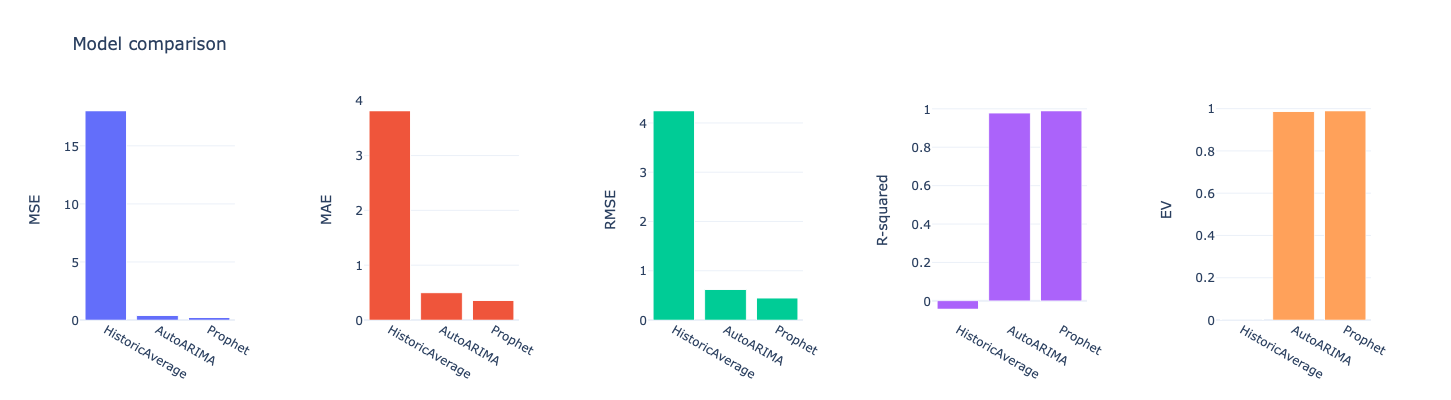

In [20]:
visualize_metrics(results_df, baseline=True)

Interestingly, it appears that Prophet has a small edge in performance. Inspect the plot: it looks like, as time progresses, the ARIMA model is content to just keep oscillating around a certain value, and fails to capture the upwards trend well. Prophet does better in predicting the later time points. Get rid of the baseline model (HistoricAverage) to get a better look.

For the hell of it, let's go bonkers with some out-of-the-box deep learning: [NeuralProphet](https://neuralprophet.com). Overkill, yay!

### 3. NeuralProphet

> NeuralProphet is an easy to learn framework for interpretable time series forecasting. NeuralProphet is built on PyTorch and combines Neural Network and traditional time-series algorithms, inspired by Facebook Prophet and AR-Net.

In [21]:
from neuralprophet import NeuralProphet

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /var/folders/wy/blzz4kvd2mxb06z0tj0w60b00000gp/T/tmpj4ouwk9t
INFO:torch.distributed.nn.jit.instantiator:Writing /var/folders/wy/blzz4kvd2mxb06z0tj0w60b00000gp/T/tmpj4ouwk9t/_remote_module_non_scriptable.py


In [22]:
train_neural = train_sf.drop(columns=["unique_id"])
overkill_model = NeuralProphet()
overkill_model.fit(train_neural)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.392% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to 91.392% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as MS
INFO:NP.df_utils:Dataframe freq automatically defined as MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=T

Finding best initial lr:   0%|          | 0/235 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

MAE       RMSE      Loss  RegLoss  epoch
0    10.110709  12.199069  0.205315      0.0      0
1     9.573282  11.447138  0.182563      0.0      1
2     8.894675  10.559460  0.155964      0.0      2
3     7.979349   9.386716  0.123548      0.0      3
4     6.812190   7.970155  0.088830      0.0      4
..         ...        ...       ...      ...    ...
142   0.569627   0.846720  0.000823      0.0    142
143   0.570631   0.846329  0.000824      0.0    143
144   0.570434   0.847961  0.000824      0.0    144
145   0.569685   0.853686  0.000826      0.0    145
146   0.569629   0.849038  0.000825      0.0    146

[147 rows x 5 columns]

In [23]:
future = overkill_model.make_future_dataframe(
    train_neural, periods=len(val), n_historic_predictions=len(train_neural)
)
forecast = overkill_model.predict(future)[-len(val) :]

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.392% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to 91.392% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO:NP.df_utils:Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.447% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to 91.447% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO:NP.df_utils:Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.447% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to 91.447% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined fr

Predicting: 80it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


In [24]:
forecast

ds   y      yhat1     trend  season_yearly
2544 1963-01-01 NaN   2.668764  8.813665      -6.144902
2545 1963-02-01 NaN   3.304854  8.814400      -5.509546
2546 1963-03-01 NaN   5.217469  8.815064      -3.597595
2547 1963-04-01 NaN   8.507122  8.815799      -0.308677
2548 1963-05-01 NaN  11.460503  8.816511       2.643991
...         ...  ..        ...       ...            ...
3175 2015-08-01 NaN  14.702795  9.269085       5.433709
3176 2015-09-01 NaN  12.719806  9.269821       3.449985
3177 2015-10-01 NaN   9.917233  9.270533       0.646699
3178 2015-11-01 NaN   6.726761  9.271268      -2.544506
3179 2015-12-01 NaN   4.137069  9.271978      -5.134910

[636 rows x 5 columns]

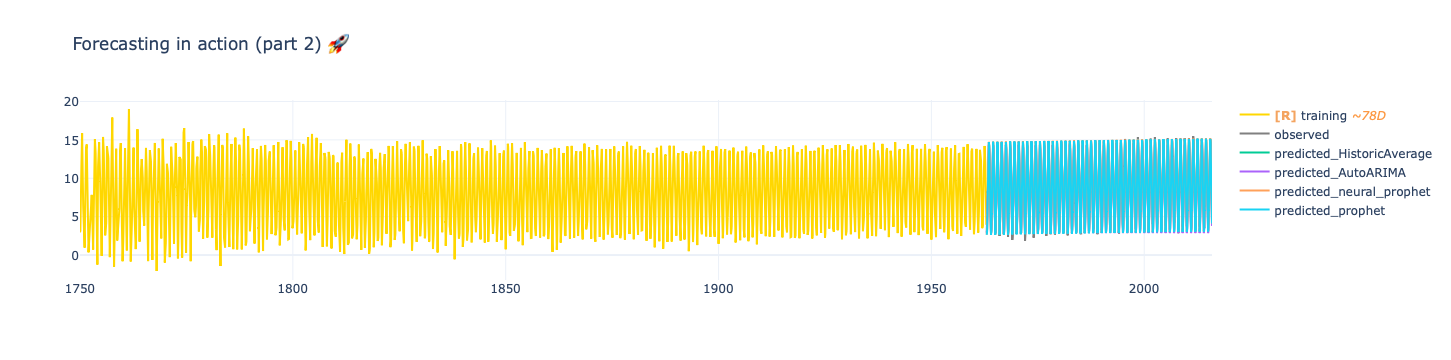

In [25]:
# Plot prophet's prediction
neural_plot = [
    go.Scatter(
        x=forecast.ds, y=forecast.yhat1, mode="lines", name="predicted_neural_prophet"
    )
]

# Display
fig = go.Figure(data=base_plots + prediction_plots + neural_plot + prophet_plot)
fig.update_layout(title="Forecasting in action (part 2) 🚀")

fig.show()

Looks pretty similar, right? Hard to tell if we gained anything. What does the data tell us?

In [26]:
results["Neural Prophet"] = forecast_metrics(val.temperature, forecast.yhat1)
results_df = pd.DataFrame(results)
results_df

HistoricAverage  AutoARIMA   Prophet  Neural Prophet
MSE              17.998435   0.385591  0.197164        0.189557
MAE               3.812531   0.494046  0.355872        0.350033
RMSE              4.242456   0.620960  0.444031        0.435381
R-squared        -0.042374   0.977669  0.988581        0.989022
EV                0.000000   0.986248  0.988809        0.989108

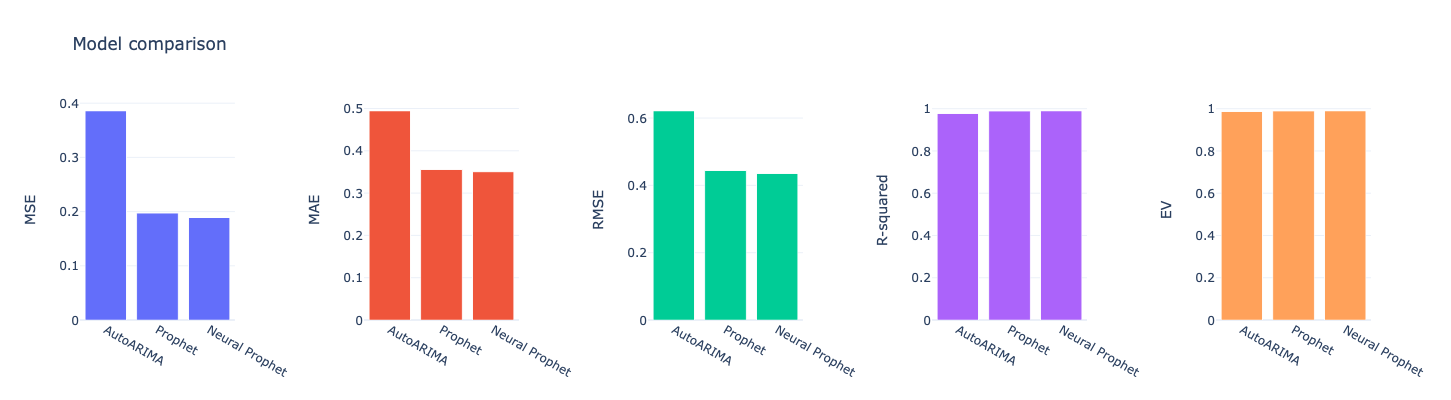

In [27]:
visualize_metrics(results_df, baseline=False)

You'll have to zoom in again, but it looks like we reduced our error yet a little more. Worth it? Depends on the time and compute we have at hand. The AutoARIMA model was actually quite expensive on both fronts. Prophet, in comparison, did fairly well! NeuralProphet did even better, but took a while longer to fit. Use the right tool for the right job!

In [ ]:
# TODO: We'll go with Neural Prophet -- package the model (to pickle?)